In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [10]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

In [11]:
from tensorflow import keras

!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.2.0-dev20200218


# Download the IMDB dataset

In [12]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Shuffling and writing examples to /Users/julian_moraes/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRDK9RG/imdb_reviews-train.tfrecord
Shuffling and writing examples to /Users/julian_moraes/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRDK9RG/imdb_reviews-test.tfrecord
Shuffling and writing examples to /Users/julian_moraes/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteRDK9RG/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /Users/julian_moraes/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [13]:
encoder = info.features['text'].encoder

In [20]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [24]:
sample_string = 'Hello TensorFlow'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120]
The original string: "Hello TensorFlow"


In [27]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow


In [39]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [44]:
decoded_example = encoder.decode(train_example)

print(decoded_example)

print(encoder.encode(decoded_example))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
[62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 

# Prepare Data for Training

In [45]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

In [53]:
for example_batch, label_batch in train_batches.take(2):    
    print("Batch shape:", example_batch.shape)
    print("label shape:", label_batch.shape)

Batch shape: (32, 970)
label shape: (32,)
Batch shape: (32, 1357)
label shape: (32,)


# Build the Model

Hyper Parameters to tune: # of layers in NN and # of hidden units

In [55]:
print(encoder.vocab_size)

model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

8185
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [76]:
history = model.fit(train_batches,
                    epochs=20,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/20
782/782 [==============================] - 4s 5ms/step - loss: 0.2730 - accuracy: 0.8921 - val_loss: 0.3559 - val_accuracy: 0.8646
Epoch 2/20
782/782 [==============================] - 3s 4ms/step - loss: 0.2607 - accuracy: 0.8981 - val_loss: 0.3510 - val_accuracy: 0.8646
Epoch 3/20
782/782 [==============================] - 3s 3ms/step - loss: 0.2489 - accuracy: 0.9040 - val_loss: 0.3469 - val_accuracy: 0.8646
Epoch 4/20
782/782 [==============================] - 3s 3ms/step - loss: 0.2386 - accuracy: 0.9072 - val_loss: 0.3442 - val_accuracy: 0.8656
Epoch 5/20
782/782 [==============================] - 3s 4ms/step - loss: 0.2297 - accuracy: 0.9109 - val_loss: 0.3443 - val_accuracy: 0.8635
Epoch 6/20
782/782 [==============================] - 3s 4ms/step - loss: 0.2204 - accuracy: 0.9160 - val_loss: 0.3413 - val_accuracy: 0.8667
Epoch 7/20
782/782 [==============================] - 3s 4ms/step - loss: 0.2125 - accuracy: 0.9184 - val_loss: 0.3423 - val_accuracy: 0.8615
Epoch 

In [77]:
loss, accuracy = model.evaluate(test_batches)

print("\n\tLoss: ", loss)
print("\tAccuracy: ", accuracy)

    782/Unknown - 2s 2ms/step - loss: 0.3380 - accuracy: 0.8660
	Loss:  0.3380372981300287
	Accuracy:  0.86604


In [78]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

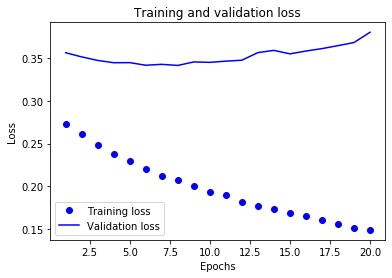

In [79]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

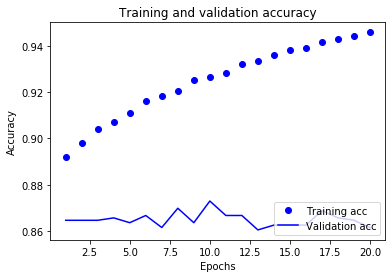

In [80]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()